In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 4200 files belonging to 5 classes.
Found 399 files belonging to 5 classes.
Found 4200 files belonging to 5 classes.
Found 399 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Pretraining Epoch 1/20
Loss: 2.8869
Pretraining Epoch 2/20
Loss: 2.9476
Pretraining Epoch 3/20
Loss: 3.0364
Pretraining Epoch 4/20
Loss: 2.8362
Pretraining Epoch 5/20
Loss: 2.8875
Pretraining Epoch 6/20
Loss: 2.9660
Pretraining Epoch 7/20
Loss: 2.8581
Pretraining Epoch 8/20
Loss: 2.9108
Pretraining Epoch 9/20
Loss: 2.9018
Pretraining Epoch 10/20
Loss: 2.9163
Pretraining Epoch 11/20
Loss: 2.8219
Pretraining Epoch 12/20
Loss: 2.8281
Pretraining Epoch 13/20
Loss: 2.8498
Pretraining Epoch 14/20
Loss: 2.9202
Pretraining Epoch 15/20
Loss: 2.8440
Pretraining Epoch 16/20
Loss: 2.8523
Pretraining Epoch 17/20
Loss: 2.8531
Pretraining Epoch 18/20
Loss: 2.8344
Pretraining Epoch 19/20
Loss: 2.8489
Pretraining Epoch 20/20
Loss: 2.8855
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 105s 357ms/step - accuracy:

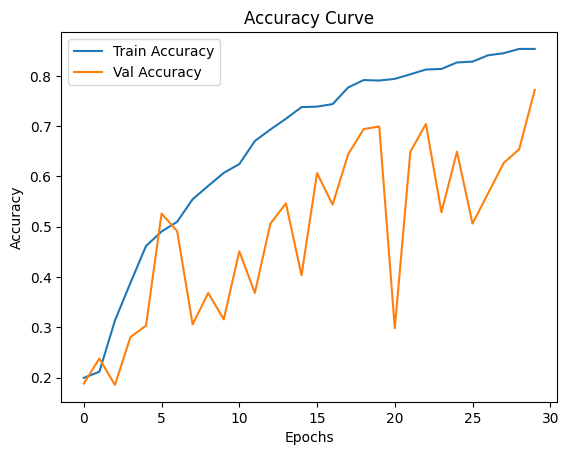

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Dataset directories
data_dir = {
    'train': '/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/train',
    'val': '/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/valid',
    'test': '/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/test'
}

# Data Augmentation
def data_augmentation(image):
    image = tf.image.resize(image, (128, 128))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Preprocess image for SimCLR pretraining
def preprocess_simclr(image, label):
    augmented_1 = data_augmentation(image)
    augmented_2 = data_augmentation(image)
    return (augmented_1, augmented_2), label

# Preprocess image for supervised training
def preprocess_supervised(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load datasets
def load_dataset(directory, preprocess_fn, batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(128, 128),
        batch_size=batch_size
    )
    dataset = dataset.map(preprocess_fn)
    return dataset

train_simclr = load_dataset(data_dir['train'], preprocess_simclr)
val_simclr = load_dataset(data_dir['val'], preprocess_simclr)

train_supervised = load_dataset(data_dir['train'], preprocess_supervised)
val_supervised = load_dataset(data_dir['val'], preprocess_supervised)
test_dataset = load_dataset(data_dir['test'], preprocess_supervised)

# SimCLR Model
def create_simclr_model(input_shape=(128, 128, 3)):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape, pooling='avg')
    projection_head = tf.keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(128)
    ])
    inputs = layers.Input(shape=input_shape)
    features = base_model(inputs, training=True)
    projections = projection_head(features)
    return Model(inputs, projections)

simclr_model = create_simclr_model()

# NT-Xent Loss Function
def nt_xent_loss(projections, temperature=0.5):
    projections = tf.math.l2_normalize(projections, axis=1)
    similarities = tf.matmul(projections, projections, transpose_b=True) / temperature
    batch_size = tf.shape(similarities)[0]
    labels = tf.eye(batch_size)
    mask = tf.cast(tf.eye(batch_size) == 0, tf.float32)
    logits = tf.nn.softmax(similarities * mask, axis=-1)
    loss = -tf.reduce_mean(tf.reduce_sum(labels * tf.math.log(logits + 1e-7), axis=1))
    return loss

# Pretraining SimCLR Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs_pretrain = 20

@tf.function
def train_step_simclr(model, images, optimizer):
    (augmented_1, augmented_2), _ = images
    with tf.GradientTape() as tape:
        projections_1 = model(augmented_1, training=True)
        projections_2 = model(augmented_2, training=True)
        loss = nt_xent_loss(tf.concat([projections_1, projections_2], axis=0))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

for epoch in range(epochs_pretrain):
    print(f"Pretraining Epoch {epoch + 1}/{epochs_pretrain}")
    for batch in train_simclr:
        loss = train_step_simclr(simclr_model, batch, optimizer)
    print(f"Loss: {loss.numpy():.4f}")

# Add Classification Head for Supervised Fine-Tuning
def create_supervised_model(simclr_model, num_classes):
    inputs = simclr_model.input
    features = simclr_model.output
    classifier_head = layers.Dense(num_classes, activation='softmax')(features)
    return Model(inputs, classifier_head)

supervised_model = create_supervised_model(simclr_model, num_classes=5)

# Compile Model for Supervised Training
supervised_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune Model
epochs_finetune = 30
history = supervised_model.fit(
    train_supervised,
    validation_data=val_supervised,
    epochs=epochs_finetune
)

# Evaluate Model on Test Set
y_true, y_pred = [], []

for batch in test_dataset:
    images, labels = batch
    predictions = supervised_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot Accuracy and Loss
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
